In [1]:
from simsopt.geo import SurfaceRZFourier
import numpy as np

# File for the desired boundary magnetic surface:
filename = "tests/test_files/input.LandremanPaul2021_QA"

# Initialize the boundary magnetic surface:
nphi = 32
ntheta = 32
s = SurfaceRZFourier.from_vmec_input(filename, range="half period", nphi=nphi, ntheta=ntheta)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.matshow(s.rc*1e3, norm="symlog")
#plt.colorbar()
#plt.title("Rcos")
#plt.show()
#plt.matshow(s.zs*1e3, norm="symlog")
#plt.colorbar()
#plt.title("Zsin")
#plt.show()

In [3]:
from examples.Simple import stage_two_optimization_minimal
coilss = []
fourier_limits = list(range(6,1, -1))

for limit in fourier_limits:
  mask = np.zeros_like(s.rc)
  for m,n in zip(s.m, s.n):
    if(abs(m)>=limit or abs(n)>=limit):
      s.set_rc(m,n,0.0)
      s.set_zs(m,n,0.0)

  #plt.matshow(s.rc*1e3, norm="symlog")
  #plt.colorbar()
  #plt.title(f"Rcos {limit}")
  #plt.show()

  coils = stage_two_optimization_minimal.optimize(s, nphi, ntheta)
  coilss.append(coils)


Authorization required, but no authorization protocol specified

Authorization required, but no authorization protocol specified

Authorization required, but no authorization protocol specified

CUDA backend failed to initialize: INTERNAL: no supported devices found for platform CUDA (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Initial max|B dot n|: 0.23229776488111945
Names of the dofs: ['Current2:x0', 'Current3:x0', 'Current4:x0', 'CurveXYZFourier1:xc(0)', 'CurveXYZFourier1:xs(1)', 'CurveXYZFourier1:xc(1)', 'CurveXYZFourier1:xs(2)', 'CurveXYZFourier1:xc(2)', 'CurveXYZFourier1:xs(3)', 'CurveXYZFourier1:xc(3)', 'CurveXYZFourier1:xs(4)', 'CurveXYZFourier1:xc(4)', 'CurveXYZFourier1:xs(5)', 'CurveXYZFourier1:xc(5)', 'CurveXYZFourier1:yc(0)', 'CurveXYZFourier1:ys(1)', 'CurveXYZFourier1:yc(1)', 'CurveXYZFourier1:ys(2)', 'CurveXYZFourier1:yc(2)', 'CurveXYZFourier1:ys(3)', 'CurveXYZFourier1:yc(3)', 'CurveXYZFourier1:ys(4)', 'CurveXYZFourier1:yc(4)', 'CurveXYZFourier1:ys(5)', 'CurveXYZFourier1:yc(5)', 'CurveXYZFourier1:zc(0)', 'CurveXYZFourier1:zs(1)', 'CurveXYZFourier1:zc(1)', 'CurveXYZFourier1:zs(2)', 'CurveXYZFourier1:zc(2)', 'CurveXYZFourier1:zs(3)', 'CurveXYZFourier1:zc(3)', 'CurveXYZFourier1:zs(4)', 'CurveXYZFourier1:zc(4)', 'CurveXYZFourier1:zs(5)', 'CurveXYZFourier1:zc(5)', 'CurveXYZFourier2:xc(0)', 'CurveXYZ

 This problem is unconstrained.



At iterate    5    f=  1.43519D-04    |proj g|=  1.12436D-03

At iterate   10    f=  3.20093D-05    |proj g|=  2.51573D-04

At iterate   15    f=  1.44070D-05    |proj g|=  1.24098D-04

At iterate   20    f=  4.93759D-06    |proj g|=  6.43150D-05

At iterate   25    f=  2.25886D-06    |proj g|=  8.87826D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  2.04200D-06    |proj g|=  7.67712D-04

At iterate   35    f=  1.87761D-06    |proj g|=  3.04152D-05

At iterate   40    f=  1.73936D-06    |proj g|=  1.32162D-04

At iterate   45    f=  1.68238D-06    |proj g|=  4.84535D-04

At iterate   50    f=  1.61780D-06    |proj g|=  3.40047D-05

At iterate   55    f=  1.58339D-06    |proj g|=  1.16232D-04

At iterate   60    f=  1.56148D-06    |proj g|=  1.56329D-05

At iterate   65    f=  1.50323D-06    |proj g|=  1.19457D-05

At iterate   70    f=  1.44694D-06    |proj g|=  2.12641D-04

At iterate   75    f=  1.41599D-06    |proj g|=  7.34347D-05

At iterate   80    f=  1.38718D-06    |proj g|=  2.42703D-04

At iterate   85    f=  1.33759D-06    |proj g|=  9.64671D-05

At iterate   90    f=  1.27997D-06    |proj g|=  3.38461D-04

At iterate   95    f=  1.25842D-06    |proj g|=  8.36790D-06

At iterate  100    f=  1.24495D-06    |proj g|=  3.32576D-05

At iterate  105    f=  1.20922D-06    |proj g|=  2.78804D-04

At iter

 This problem is unconstrained.



At iterate    5    f=  1.44074D-04    |proj g|=  1.12712D-03

At iterate   10    f=  3.21200D-05    |proj g|=  2.47061D-04

At iterate   15    f=  1.45061D-05    |proj g|=  1.29520D-04

At iterate   20    f=  5.03431D-06    |proj g|=  5.53041D-05

At iterate   25    f=  2.37019D-06    |proj g|=  2.99668D-04

At iterate   30    f=  1.70167D-06    |proj g|=  9.33590D-06



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  1.56235D-06    |proj g|=  3.34015D-05

At iterate   40    f=  1.51717D-06    |proj g|=  4.37261D-05

At iterate   45    f=  1.48669D-06    |proj g|=  3.38364D-04

At iterate   50    f=  1.45253D-06    |proj g|=  2.09219D-04

At iterate   55    f=  1.42142D-06    |proj g|=  2.75542D-04

At iterate   60    f=  1.41309D-06    |proj g|=  1.10520D-05

At iterate   65    f=  1.36911D-06    |proj g|=  2.72630D-04

At iterate   70    f=  1.31560D-06    |proj g|=  3.52136D-05

At iterate   75    f=  1.30232D-06    |proj g|=  2.42872D-04

At iterate   80    f=  1.26788D-06    |proj g|=  1.26198D-05

At iterate   85    f=  1.20455D-06    |proj g|=  3.27846D-04

At iterate   90    f=  1.16830D-06    |proj g|=  1.12334D-04

At iterate   95    f=  1.12858D-06    |proj g|=  1.62553D-05

At iterate  100    f=  1.08893D-06    |proj g|=  5.73578D-05

At iterate  105    f=  1.07866D-06    |proj g|=  4.00380D-05

At iterate  110    f=  1.07117D-06    |proj g|=  9.28823D-06

At iter

 This problem is unconstrained.



At iterate    5    f=  1.44010D-04    |proj g|=  1.15070D-03

At iterate   10    f=  3.26523D-05    |proj g|=  2.21169D-04

At iterate   15    f=  1.47507D-05    |proj g|=  1.25052D-04

At iterate   20    f=  6.09176D-06    |proj g|=  7.09069D-05

At iterate   25    f=  2.85187D-06    |proj g|=  3.36763D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  2.36788D-06    |proj g|=  4.16924D-05

At iterate   35    f=  2.15655D-06    |proj g|=  2.04611D-04

At iterate   40    f=  2.06076D-06    |proj g|=  9.02882D-05

At iterate   45    f=  1.93801D-06    |proj g|=  6.25282D-04

At iterate   50    f=  1.86157D-06    |proj g|=  2.51482D-04

At iterate   55    f=  1.83861D-06    |proj g|=  1.29254D-05

At iterate   60    f=  1.72996D-06    |proj g|=  3.97365D-04

At iterate   65    f=  1.66910D-06    |proj g|=  1.84134D-04

At iterate   70    f=  1.61555D-06    |proj g|=  5.69268D-04

At iterate   75    f=  1.54414D-06    |proj g|=  3.24212D-04

At iterate   80    f=  1.48173D-06    |proj g|=  2.65496D-05

At iterate   85    f=  1.46582D-06    |proj g|=  6.54681D-05

At iterate   90    f=  1.40726D-06    |proj g|=  1.22102D-05

At iterate   95    f=  1.35379D-06    |proj g|=  5.09533D-05

At iterate  100    f=  1.32065D-06    |proj g|=  1.60115D-04

At iterate  105    f=  1.30896D-06    |proj g|=  8.27726D-05

At iter

 This problem is unconstrained.



At iterate   15    f=  1.38123D-05    |proj g|=  7.78962D-05

At iterate   20    f=  5.34294D-06    |proj g|=  3.55031D-05

At iterate   25    f=  2.89992D-06    |proj g|=  6.01548D-05

At iterate   30    f=  2.24157D-06    |proj g|=  1.81451D-05

At iterate   35    f=  1.68606D-06    |proj g|=  1.39222D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  1.62496D-06    |proj g|=  1.33188D-05

At iterate   45    f=  1.58541D-06    |proj g|=  9.48532D-05

At iterate   50    f=  1.53845D-06    |proj g|=  1.45712D-05

At iterate   55    f=  1.51023D-06    |proj g|=  2.31029D-04

At iterate   60    f=  1.49199D-06    |proj g|=  1.48692D-05

At iterate   65    f=  1.45884D-06    |proj g|=  3.78941D-05

At iterate   70    f=  1.42701D-06    |proj g|=  4.36872D-05

At iterate   75    f=  1.40822D-06    |proj g|=  1.04613D-05

At iterate   80    f=  1.37920D-06    |proj g|=  3.64932D-05

At iterate   85    f=  1.37074D-06    |proj g|=  6.96680D-05

At iterate   90    f=  1.33308D-06    |proj g|=  1.09285D-05

At iterate   95    f=  1.32646D-06    |proj g|=  1.14222D-04

At iterate  100    f=  1.27970D-06    |proj g|=  7.67607D-05

At iterate  105    f=  1.26119D-06    |proj g|=  1.68028D-04

At iterate  110    f=  1.22944D-06    |proj g|=  4.08508D-04

At iterate  115    f=  1.16006D-06    |proj g|=  6.40274D-04

At iter

 This problem is unconstrained.



At iterate   10    f=  7.54124D-05    |proj g|=  3.94485D-04

At iterate   15    f=  2.05645D-05    |proj g|=  1.85224D-04

At iterate   20    f=  7.99180D-06    |proj g|=  8.42637D-05

At iterate   25    f=  4.10859D-06    |proj g|=  1.26053D-04

At iterate   30    f=  3.10705D-06    |proj g|=  2.97532D-05

At iterate   35    f=  2.60741D-06    |proj g|=  3.25230D-04

At iterate   40    f=  2.45575D-06    |proj g|=  5.77432D-04

At iterate   45    f=  2.38932D-06    |proj g|=  2.00697D-04

At iterate   50    f=  2.28982D-06    |proj g|=  1.14288D-05

At iterate   55    f=  2.19435D-06    |proj g|=  1.81494D-05

At iterate   60    f=  2.11121D-06    |proj g|=  2.74014D-04

At iterate   65    f=  2.05730D-06    |proj g|=  5.43777D-04

At iterate   70    f=  1.96800D-06    |proj g|=  3.75938D-04

At iterate   75    f=  1.91975D-06    |proj g|=  3.62456D-04

At iterate   80    f=  1.82968D-06    |proj g|=  6.28530D-04

At iterate   85    f=  1.77040D-06    |proj g|=  1.12053D-04

At iter

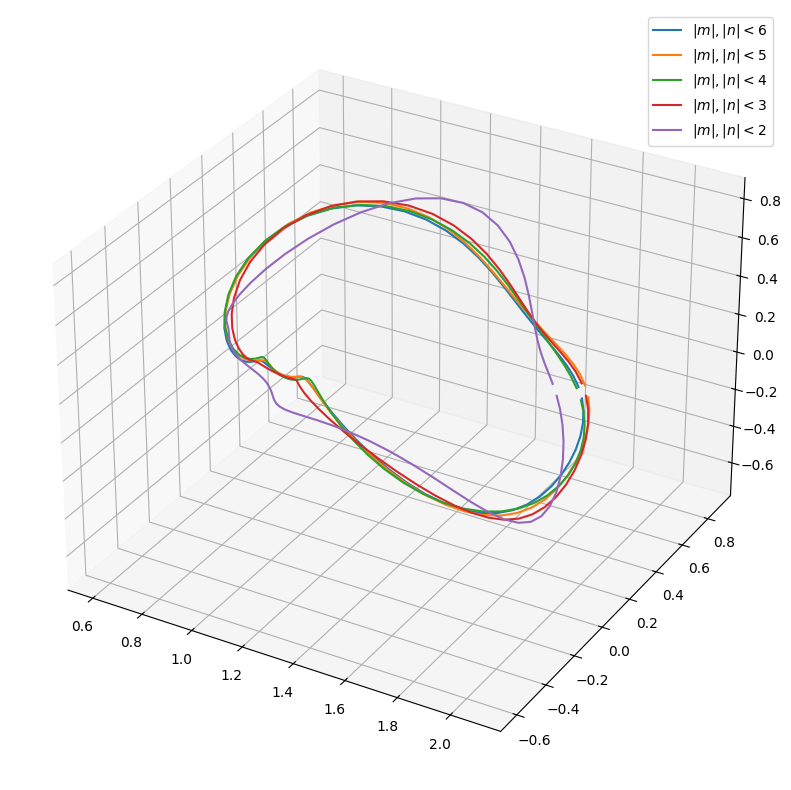

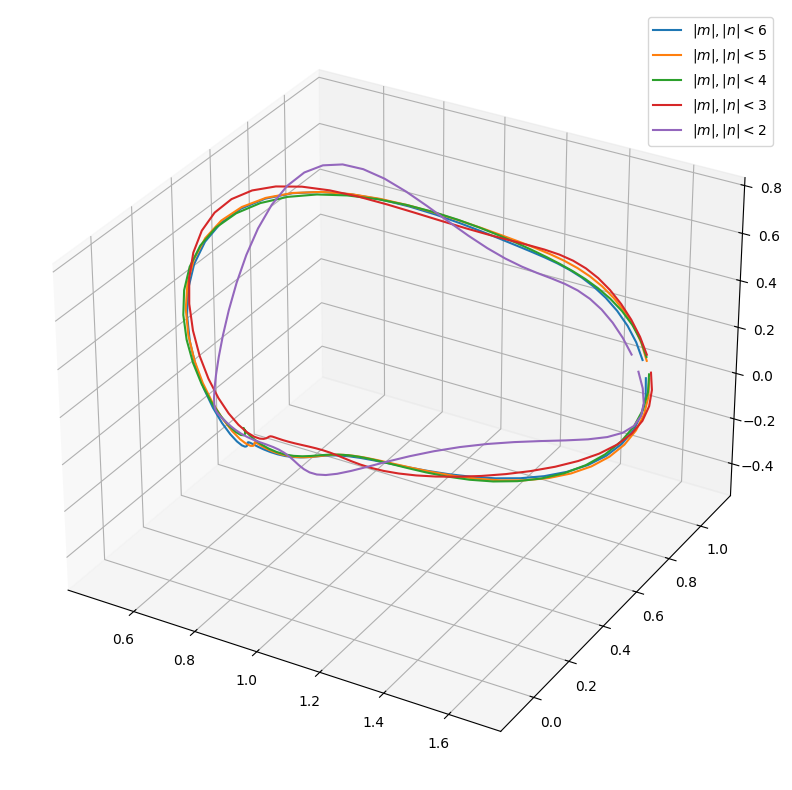

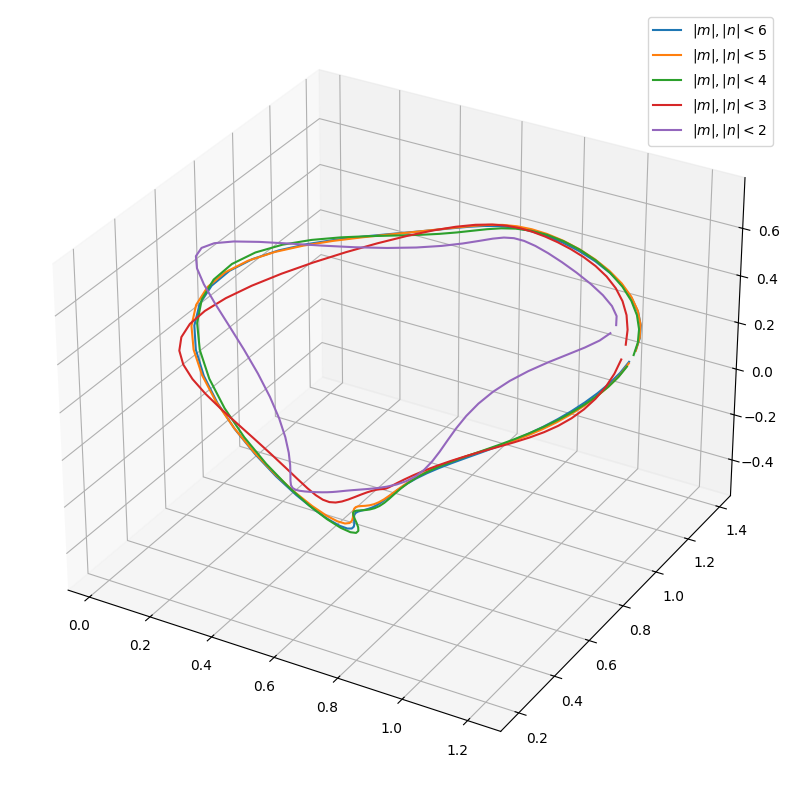

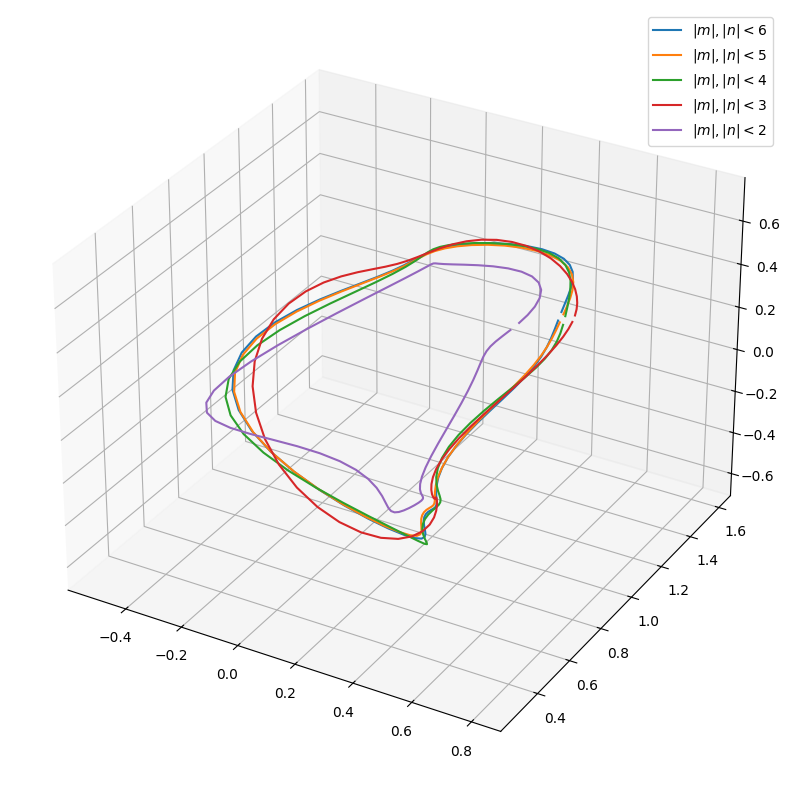

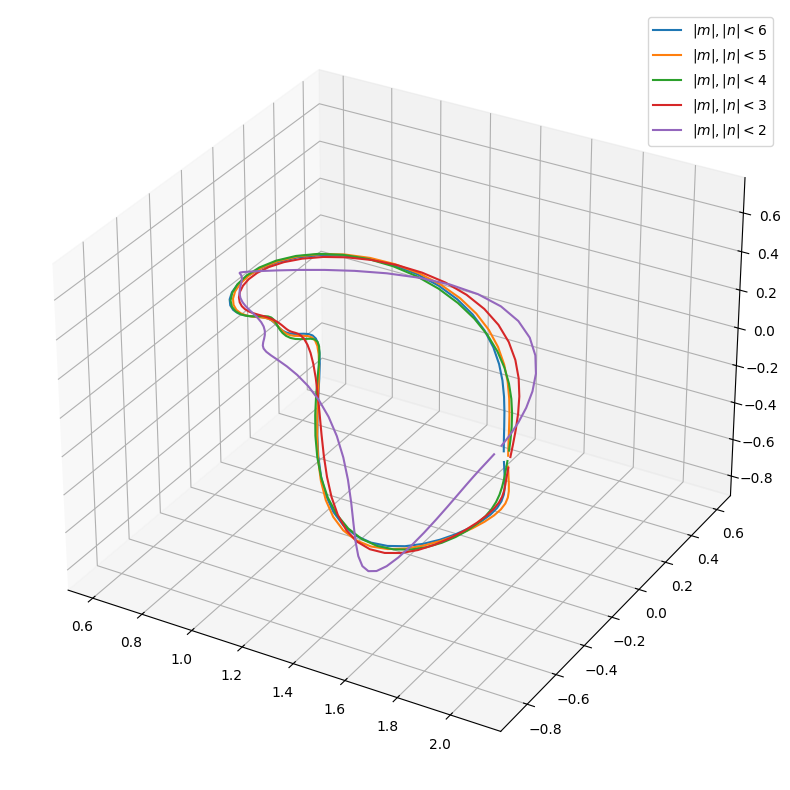

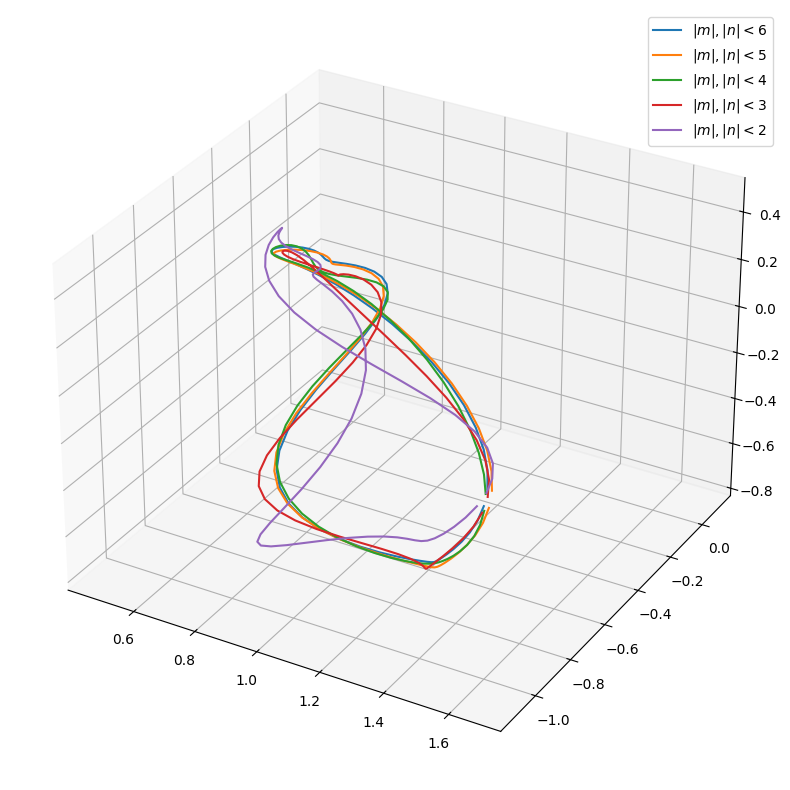

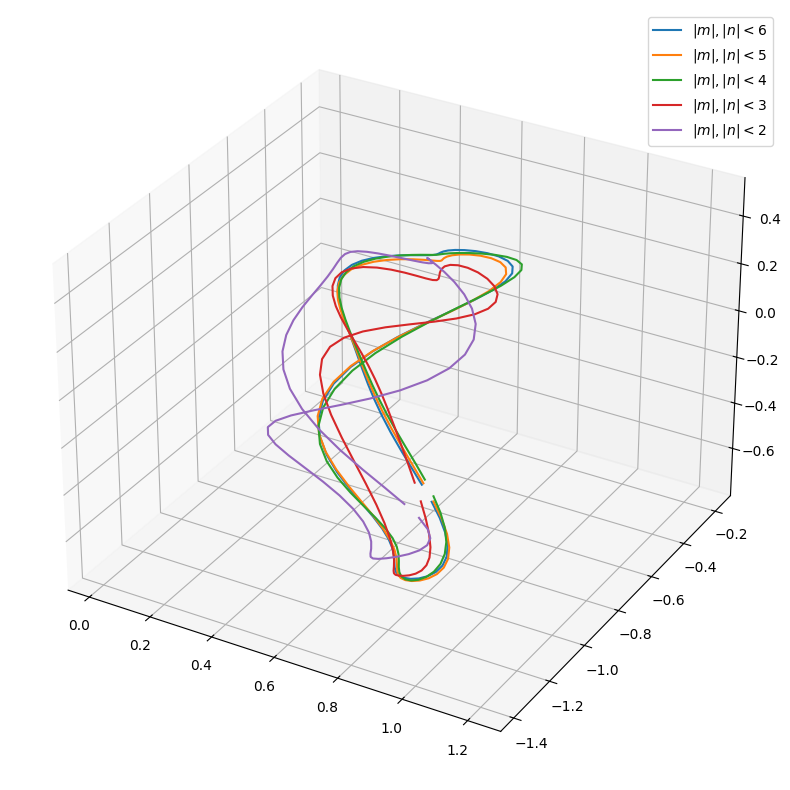

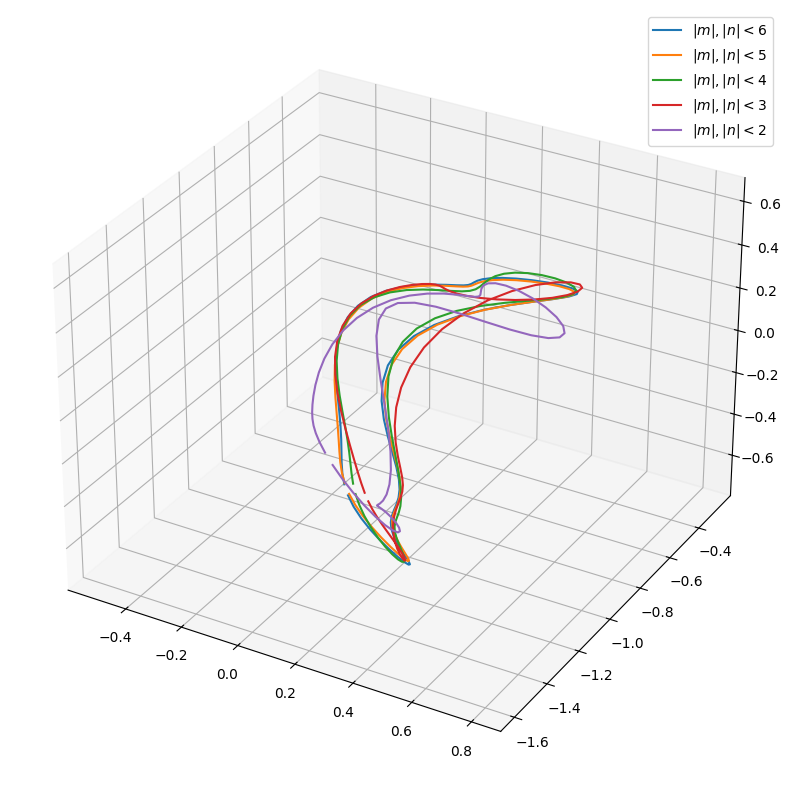

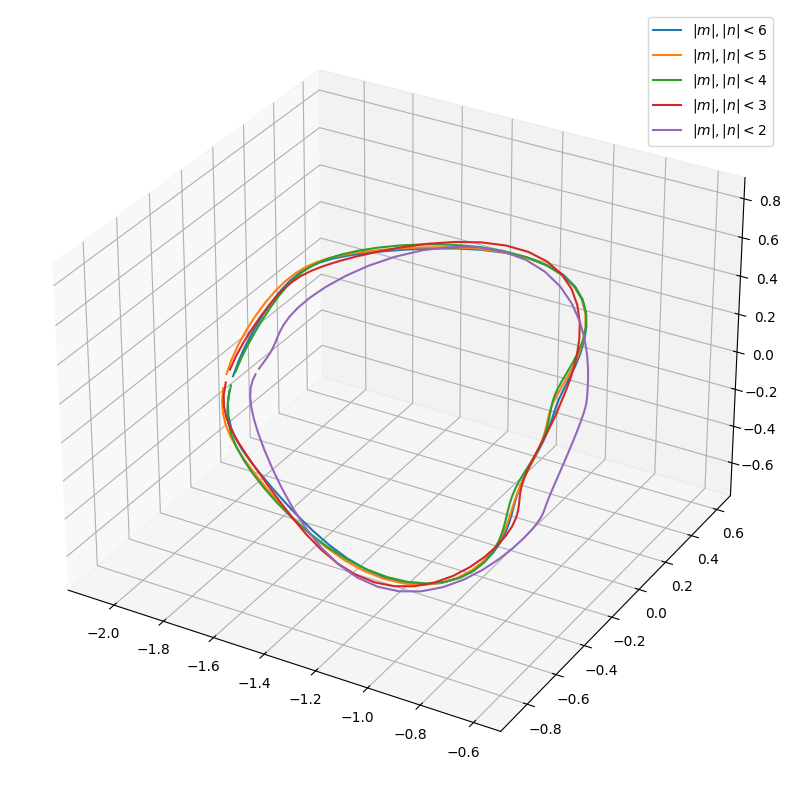

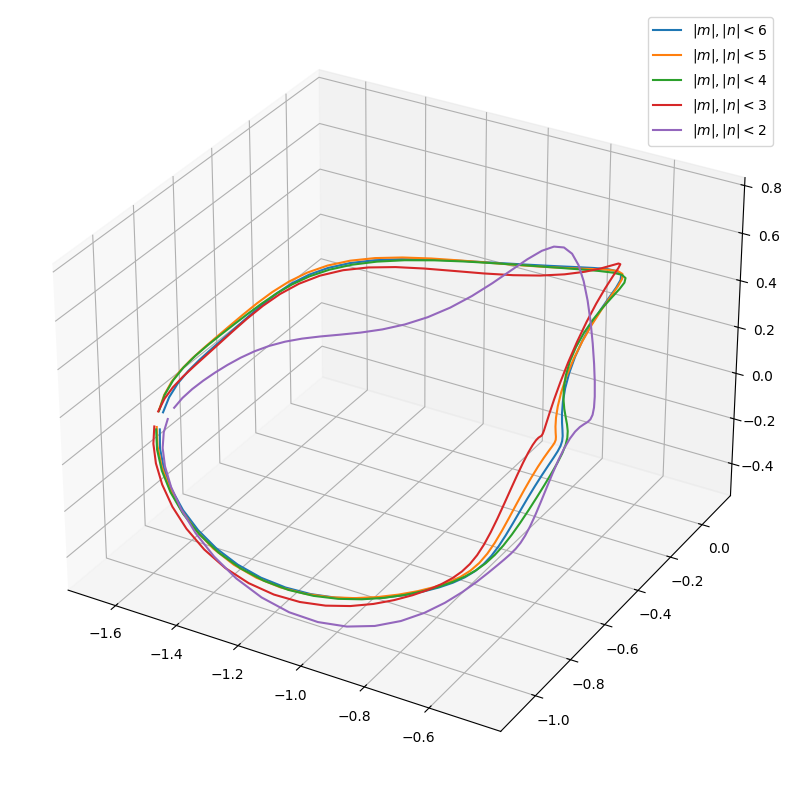

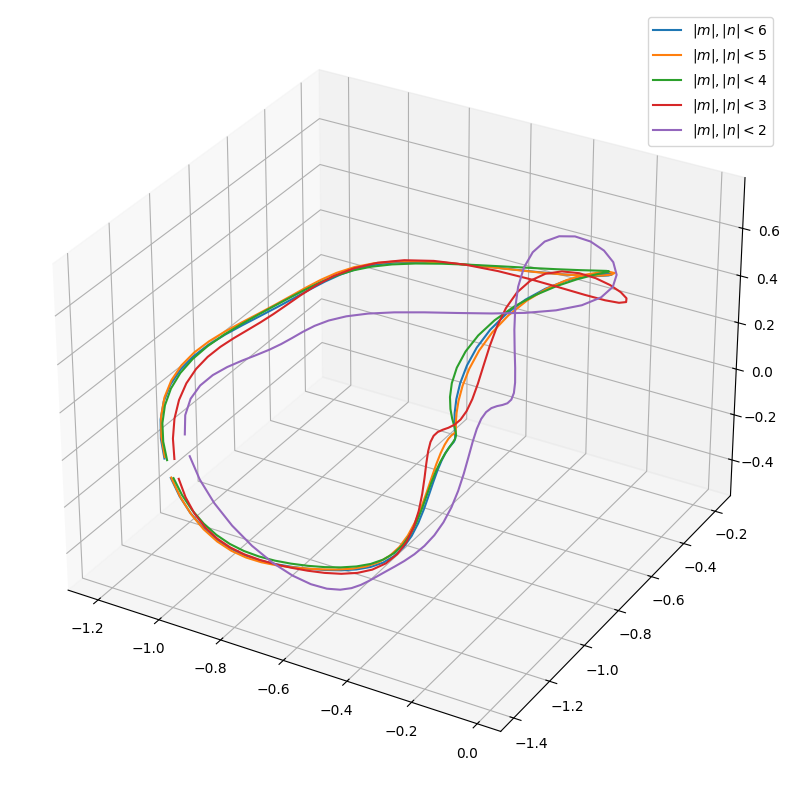

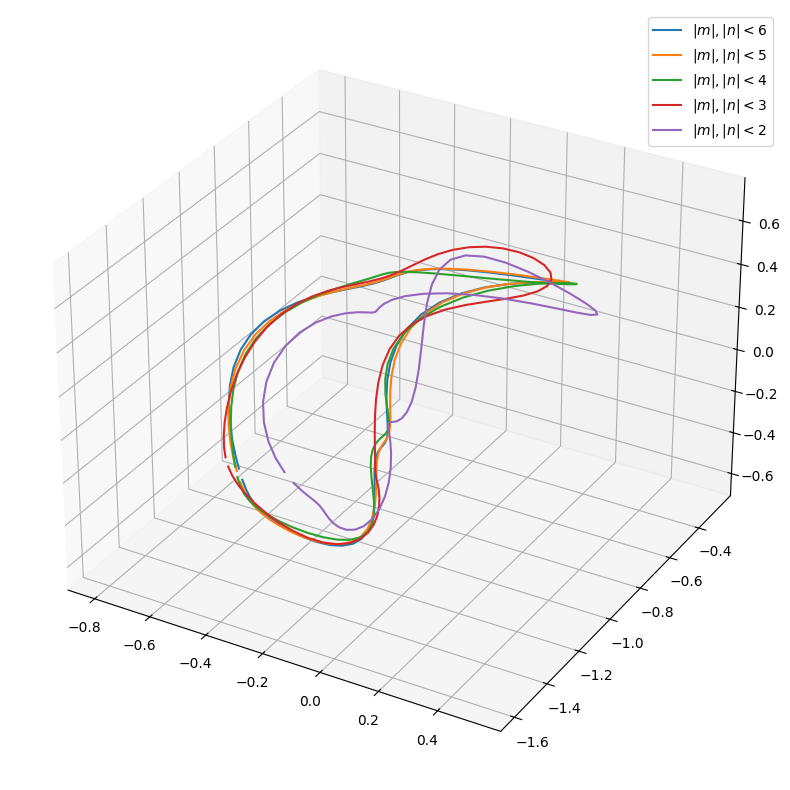

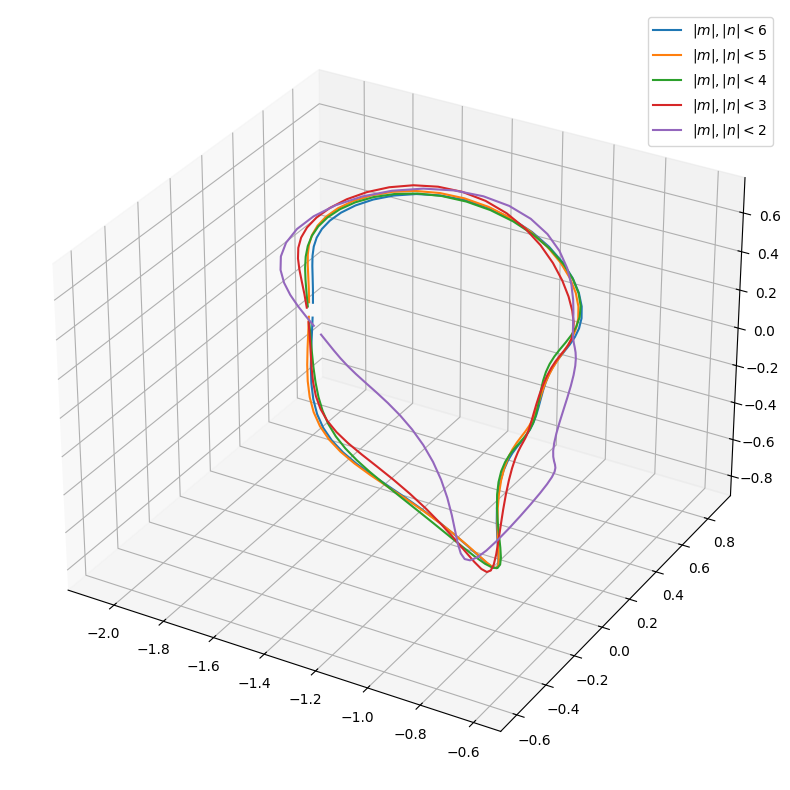

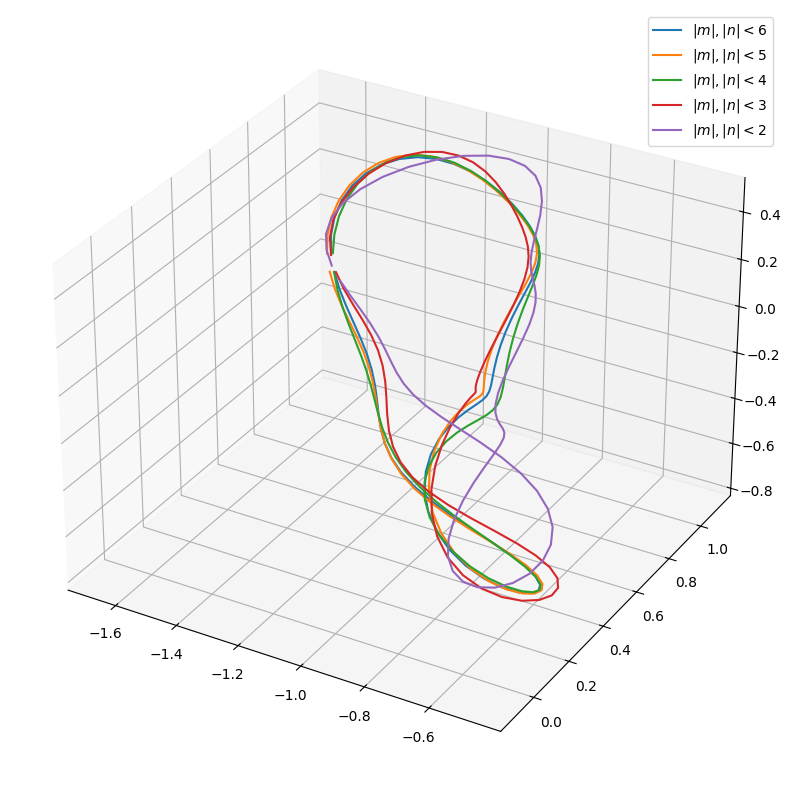

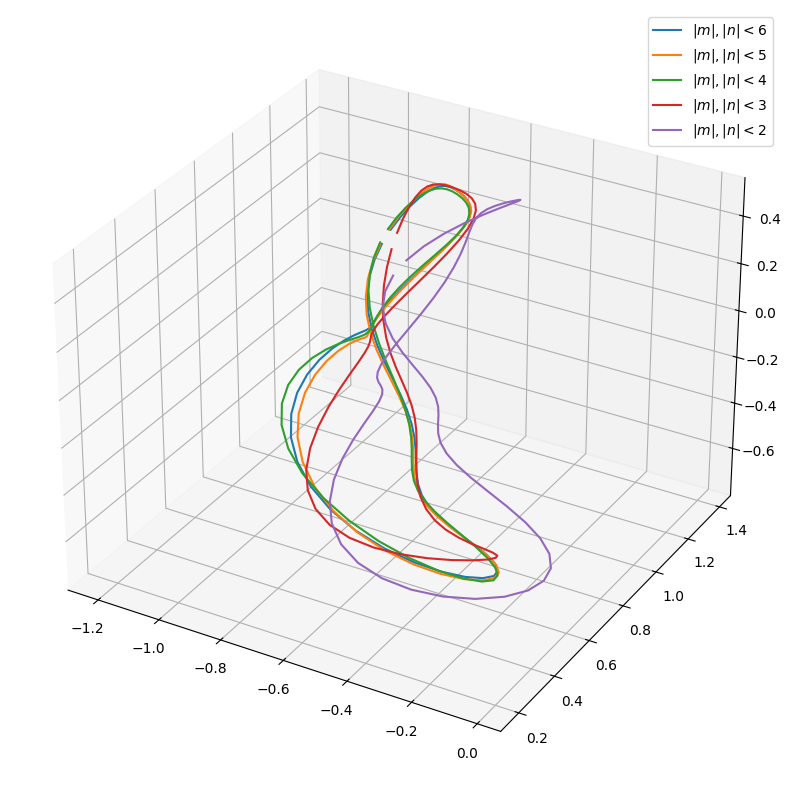

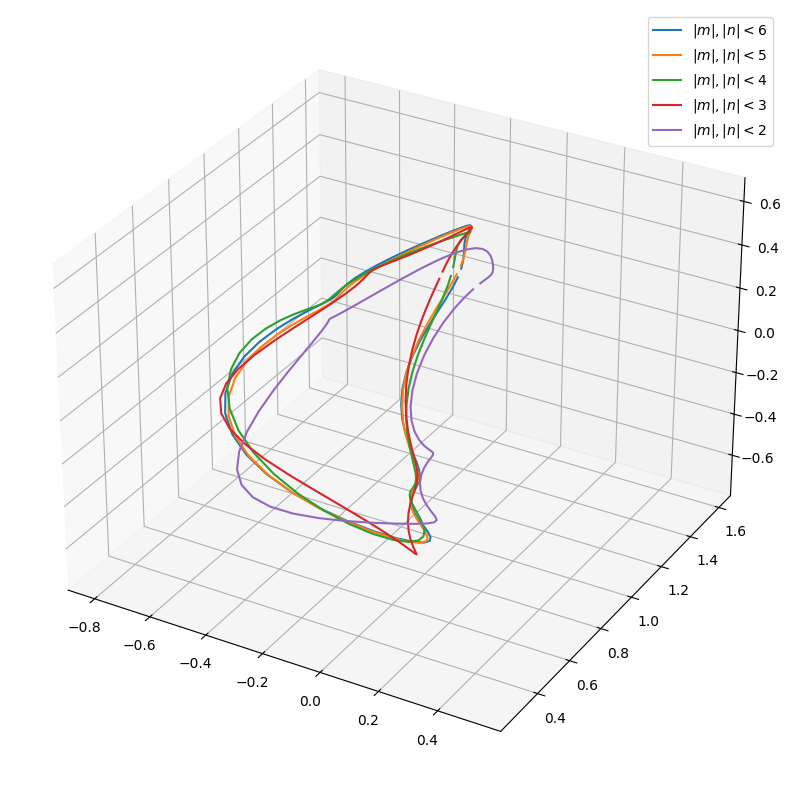

In [42]:
from simsopt.geo import plot

for coil_i in range(len(coilss[0])):
  ax = plt.figure(figsize=(16,10)).add_subplot(projection='3d')
  for coils in coilss:
    coils[coil_i].plot(ax=ax, show=False)
  plt.legend([f"$|m|,|n|<{limit}$" for limit in fourier_limits])
  ax.set_prop_cycle(None)